# Importing Libraries

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import plotly.graph_objs as go

from pandas_profiling import ProfileReport
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_squared_error, accuracy_score, mean_absolute_error

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)
plt.style.use("dark_background")

import warnings
warnings.filterwarnings('ignore')

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/autompg-dataset/auto-mpg.csv


In [2]:
auto_df = pd.read_csv("../input/autompg-dataset/auto-mpg.csv", na_values=['?'])

# Data Description + Cleaning

In [3]:
auto_df['car name'] = auto_df['car name'].replace(['volkswagen','vokswagen','vw'],'volkswagen')
auto_df['car name'] = auto_df['car name'].replace('maxda','mazda')
auto_df['car name'] = auto_df['car name'].replace('toyouta','toyota')
auto_df['car name'] = auto_df['car name'].replace('capri','ford')
auto_df['car name'] = auto_df['car name'].replace(['chevroelt','chevy'],'chevrolet')

In [4]:
def check_df(dataFrame, head = 10):
    print(" SHAPE ".center(140,'-'))
    print('Rows: {}'.format(dataFrame.shape[0]))
    print('Columns: {}'.format(dataFrame.shape[1]))
    print(" TYPES ".center(140,'-'))
    print(dataFrame.dtypes)
    print(" HEAD ".center(140,'-'))
    print(dataFrame.head(head))
    print(' TAIL '.center(140,'-'))
    print(dataFrame.tail(head))
    print(' MISSING VALUES '.center(140,'-'))
    print(dataFrame.isnull().sum())
    print(' CORRELATED VALUES '.center(140,'-'))
    print(dataFrame.corr())
    print(' DUPLICATED VALUES '.center(140,'-'))
    print(dataFrame.duplicated().sum())
    
check_df(auto_df)

------------------------------------------------------------------ SHAPE -------------------------------------------------------------------
Rows: 398
Columns: 9
------------------------------------------------------------------ TYPES -------------------------------------------------------------------
mpg             float64
cylinders         int64
displacement    float64
horsepower      float64
weight            int64
acceleration    float64
model year        int64
origin            int64
car name         object
dtype: object
------------------------------------------------------------------- HEAD -------------------------------------------------------------------
    mpg  cylinders  displacement  horsepower  weight  acceleration  \
0  18.0          8         307.0       130.0    3504          12.0   
1  15.0          8         350.0       165.0    3693          11.5   
2  18.0          8         318.0       150.0    3436          11.0   
3  16.0          8         304.0       150.0  

In [5]:
auto_df.drop('car name', axis=1, inplace=True)

In [6]:
auto_df['origin'] = auto_df['origin'].replace([1, 2, 3], ['USA', 'Europe', 'Japan'])

In [7]:
auto_df.head(10)

mpg  cylinders  displacement  horsepower  weight  acceleration  \
0  18.0          8         307.0       130.0    3504          12.0   
1  15.0          8         350.0       165.0    3693          11.5   
2  18.0          8         318.0       150.0    3436          11.0   
3  16.0          8         304.0       150.0    3433          12.0   
4  17.0          8         302.0       140.0    3449          10.5   
5  15.0          8         429.0       198.0    4341          10.0   
6  14.0          8         454.0       220.0    4354           9.0   
7  14.0          8         440.0       215.0    4312           8.5   
8  14.0          8         455.0       225.0    4425          10.0   
9  15.0          8         390.0       190.0    3850           8.5   

   model year origin  
0          70    USA  
1          70    USA  
2          70    USA  
3          70    USA  
4          70    USA  
5          70    USA  
6          70    USA  
7          70    USA  
8          70    USA  
9          70    USA

In [8]:
auto_df['origin'].value_counts()

USA       249
Japan      79
Europe     70
Name: origin, dtype: int64

In [9]:
auto_df.isnull().sum()

mpg             0
cylinders       0
displacement    0
horsepower      6
weight          0
acceleration    0
model year      0
origin          0
dtype: int64

In [10]:
auto_df.isnull().sum()/auto_df.shape[0]

mpg             0.000000
cylinders       0.000000
displacement    0.000000
horsepower      0.015075
weight          0.000000
acceleration    0.000000
model year      0.000000
origin          0.000000
dtype: float64

In [11]:
 auto_df.profile_report()

Summarize dataset:   0%|          | 0/21 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

# EDA

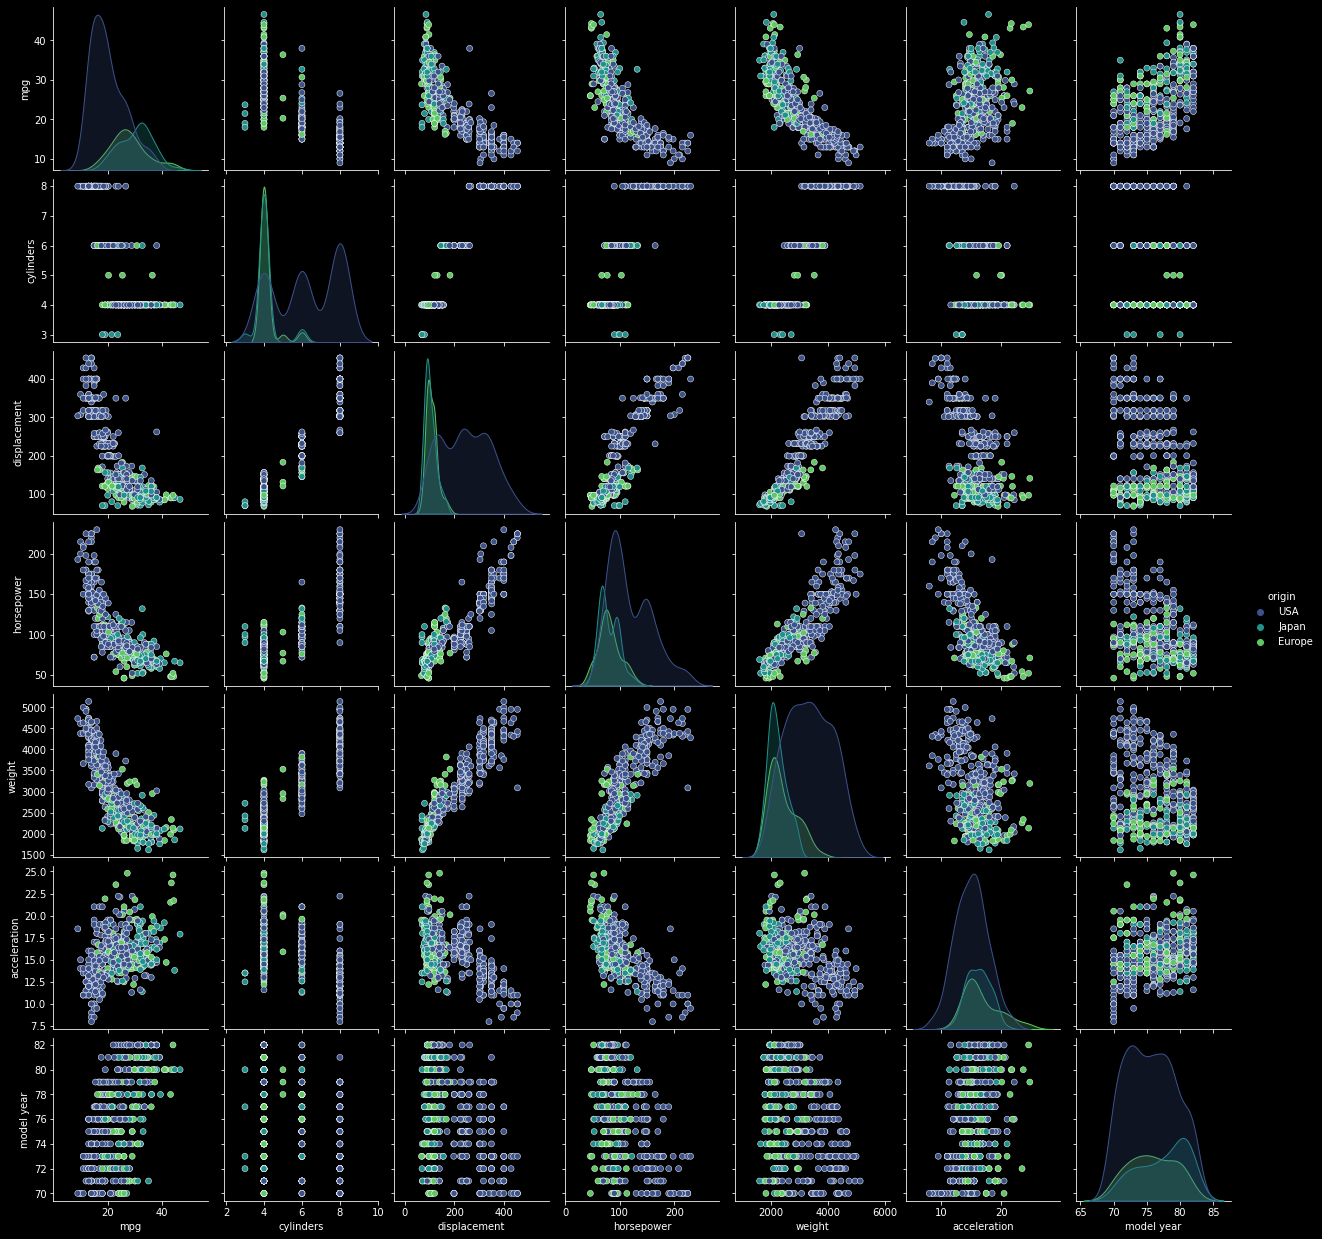

In [12]:
sns.pairplot(auto_df, hue="origin", palette="viridis")

(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5]),
 [Text(0, 0.5, 'mpg'),
  Text(0, 1.5, 'cylinders'),
  Text(0, 2.5, 'displacement'),
  Text(0, 3.5, 'horsepower'),
  Text(0, 4.5, 'weight'),
  Text(0, 5.5, 'acceleration'),
  Text(0, 6.5, 'model year')])

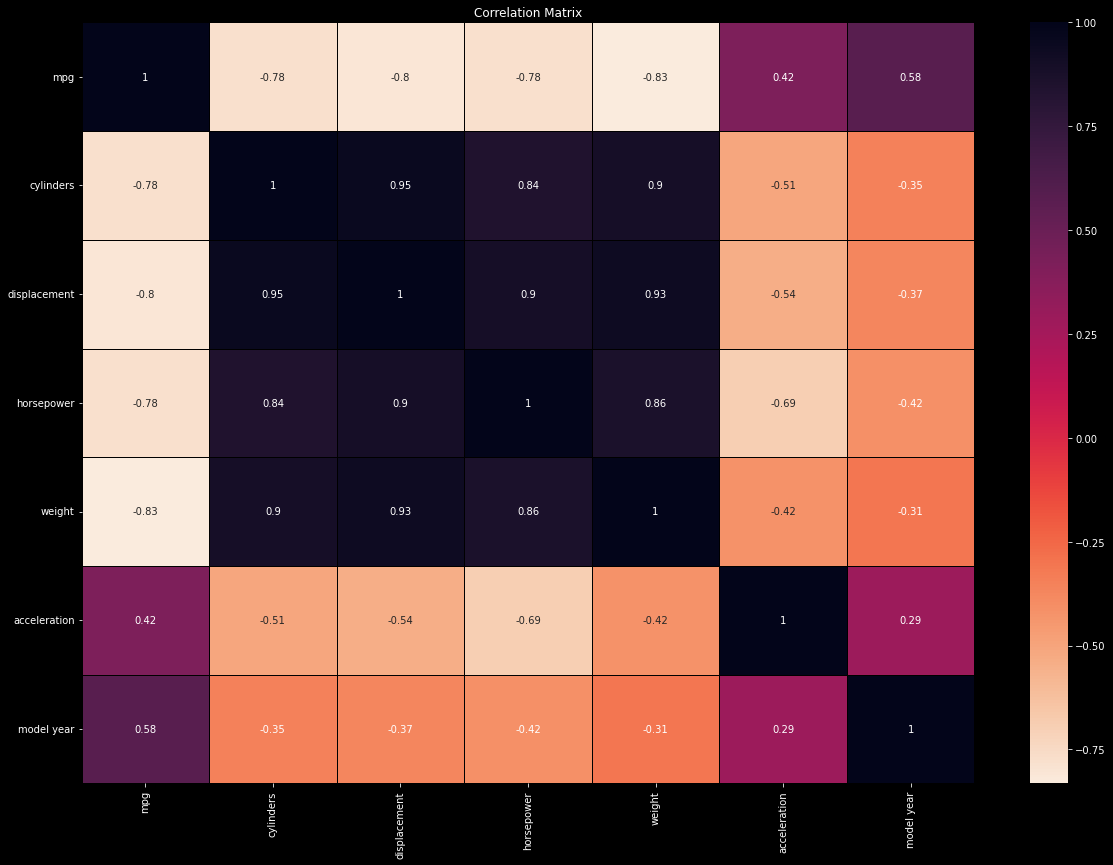

In [13]:
plt.figure(figsize=(20,14))
sns.heatmap(auto_df.corr(), linewidths = 1.0, linecolor = 'black', annot=True, cmap='rocket_r')
plt.title('Correlation Matrix')
plt.xticks(rotation=90)
plt.yticks(rotation=0)

In [14]:
data = [go.Scatter(x = auto_df['horsepower'], 
                  y = auto_df['mpg'],
                  mode = 'markers',
                  marker=dict(color=auto_df['cylinders'],
                               size=1.5*auto_df['cylinders'],
                               showscale=True)
                  )]

layout = go.Layout(title = 'Plotly Auto-mpg')

fig = go.Figure(data = data, layout = layout)
fig.show()

# Feature Engineering

In [15]:
origin = auto_df.pop('origin')

In [16]:
auto_df['USA'] = (origin == 1) * 1.0
auto_df['Europe'] = (origin == 2) * 1.0
auto_df['Japan'] = (origin == 3) * 1.0

In [17]:
X = auto_df.drop(['mpg'], axis = 1)
y = auto_df['mpg']

# Train Test Split

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [19]:
X_train.shape

(298, 9)

In [20]:
X_test.shape

(100, 9)

In [21]:
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [22]:
print(X_train.shape)
print(X_test.shape)

(298, 9)
(100, 9)


# XGBoost Regression Model Training

In [23]:
xgb_params = {'nthread': [3],
              'n_jobs': [3, 4],
              'objective': ['reg:linear'], 
              'learning_rate':[0.03, 0.05, 0.07, 0.1],
              'n_estimators':[250, 500, 750, 1000],
              'max_depth': [4, 5, 6],
              'min_child_weight': [3],
              'subsample': [0.6],
              'colsample_bytree': [0.5]}

xgb_model = XGBRegressor()

xgb_grid = GridSearchCV(xgb_model, xgb_params, cv = 5, refit = True, verbose = 2)

xgb_grid.fit(X_train, y_train)
xgb_model = xgb_grid.best_estimator_

y_predict = xgb_grid.predict(X_test)
print("Model\t\t\t\t RMSE \t\t MSE \t\t MAE \t\t R2")
print("""XGBoost Regressor \t {:.2f} \t\t {:.2f} \t\t{:.2f} \t\t{:.2f}""".format(
            np.sqrt(mean_squared_error(y_test, y_predict)),
            mean_squared_error(y_test, y_predict),
            mean_absolute_error(y_test, y_predict),
            r2_score(y_test, y_predict)))

Fitting 5 folds for each of 96 candidates, totalling 480 fits
[CV] colsample_bytree=0.5, learning_rate=0.03, max_depth=4, min_child_weight=3, n_estimators=250, n_jobs=3, nthread=3, objective=reg:linear, subsample=0.6 
[08:07:19] WARNING: ../src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  colsample_bytree=0.5, learning_rate=0.03, max_depth=4, min_child_weight=3, n_estimators=250, n_jobs=3, nthread=3, objective=reg:linear, subsample=0.6, total=   0.9s
[CV] colsample_bytree=0.5, learning_rate=0.03, max_depth=4, min_child_weight=3, n_estimators=250, n_jobs=3, nthread=3, objective=reg:linear, subsample=0.6 
[08:07:20] WARNING: ../src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s


[CV]  colsample_bytree=0.5, learning_rate=0.03, max_depth=4, min_child_weight=3, n_estimators=250, n_jobs=3, nthread=3, objective=reg:linear, subsample=0.6, total=   0.8s
[CV] colsample_bytree=0.5, learning_rate=0.03, max_depth=4, min_child_weight=3, n_estimators=250, n_jobs=3, nthread=3, objective=reg:linear, subsample=0.6 
[08:07:21] WARNING: ../src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[CV]  colsample_bytree=0.5, learning_rate=0.03, max_depth=4, min_child_weight=3, n_estimators=250, n_jobs=3, nthread=3, objective=reg:linear, subsample=0.6, total=   0.8s
[CV] colsample_bytree=0.5, learning_rate=0.03, max_depth=4, min_child_weight=3, n_estimators=250, n_jobs=3, nthread=3, objective=reg:linear, subsample=0.6 
[08:07:21] WARNING: ../src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[CV]  colsample_bytree=0.5, learning_rate=0.03, max_depth=4, min_child_weight=3, n_estimators=250, n_jobs=3,

[Parallel(n_jobs=1)]: Done 480 out of 480 | elapsed: 18.1min finished


Model				 RMSE 		 MSE 		 MAE 		 R2
XGBoost Regressor 	 2.40 		 5.77 		1.85 		0.90


In [24]:
pd.DataFrame(list(zip(y_test, y_predict)), columns = ['Actual Values', 'Predicted Values'])

Actual Values  Predicted Values
0            33.0         32.427410
1            28.0         30.994221
2            19.0         21.473597
3            13.0         15.065968
4            14.0         13.622494
5            27.0         24.855778
6            24.0         26.227016
7            13.0         11.587264
8            17.0         18.329021
9            21.0         19.056696
10           15.0         13.227757
11           38.0         36.124176
12           26.0         29.857796
13           15.0         13.884436
14           25.0         25.625851
15           12.0         12.699181
16           31.0         30.879158
17           17.0         20.245487
18           16.0         15.070534
19           31.0         36.581440
20           22.0         24.732937
21           22.0         19.123575
22           22.0         25.013283
23           33.5         29.046541
24           18.0         16.338110
25           44.0         35.173378
26           26.0         23.609446
27           24.5         23.650162
28           18.1         18.969337
29           12.0         12.434907
30           27.0         26.405861
31           36.0         33.649624
32           23.0         17.672335
33           24.0         23.277649
34           37.2         38.934929
35           16.0         12.700893
36           21.0         21.371929
37           19.2         18.120996
38           16.0         13.644607
39           29.0         25.765282
40           26.8         26.420311
41           27.0         28.597458
42           18.0         20.446201
43           10.0         11.774542
44           23.0         23.105238
45           36.0         31.819082
46           26.0         26.589149
47           25.0         23.254204
48           25.0         24.352901
49           25.0         28.080038
50           22.0         23.463493
51           34.1         35.412086
52           32.4         34.751694
53           13.0         12.112174
54           23.5         28.111044
55           14.0         13.530034
56           18.5         16.822998
57           29.8         27.407520
58           28.0         23.214148
59           19.0         18.769125
60           11.0         14.321708
61           33.0         31.742229
62           23.0         24.666283
63           21.0         19.853176
64           23.0         18.752008
65           25.0         24.693560
66           23.8         23.584623
67           34.4         34.993565
68           24.5         29.308226
69           13.0         14.251678
70           34.7         34.897263
71           14.0         13.512727
72           15.0         13.086181
73           18.0         19.019735
74           25.0         25.729149
75           19.9         20.267004
76           17.5         18.608074
77           28.0         29.674694
78           29.0         29.597242
79           17.0         17.009808
80           16.0         15.674785
81           27.0         26.113037
82           37.0         36.690052
83           36.1         33.878029
84           23.0         24.323177
85           14.0         12.990648
86           32.8         34.645409
87           29.9         34.229607
88           20.0         22.417538
89           12.0         11.734480
90           15.5         14.533651
91           23.7         30.081888
92           24.0         25.565714
93           36.0         33.373947
94           19.0         21.012913
95           38.0         36.592384
96           29.0         30.440264
97           21.5         20.383766
98           27.9         26.312796
99           14.0         13.631226

# Neural Network Model

In [25]:
# Check from here
model = Sequential()

model.add(Dense(32, activation = 'relu'))

model.add(Dense(32, activation = 'relu'))

model.add(Dense(32, activation = 'relu'))

model.add(Dense(32, activation = 'relu'))

model.add(Dense(32, activation = 'relu'))

model.add(Dense(32, activation = 'relu'))

model.add(Dense(32, activation = 'relu'))

model.add(Dense(1))


User settings:

   KMP_AFFINITY=granularity=fine,verbose,compact,1,0
   KMP_BLOCKTIME=0
   KMP_DUPLICATE_LIB_OK=True
   KMP_INIT_AT_FORK=FALSE
   KMP_SETTINGS=1
   KMP_WARNINGS=0

Effective settings:

   KMP_ABORT_DELAY=0
   KMP_ADAPTIVE_LOCK_PROPS='1,1024'
   KMP_ALIGN_ALLOC=64
   KMP_ALL_THREADPRIVATE=128
   KMP_ATOMIC_MODE=2
   KMP_BLOCKTIME=0
   KMP_CPUINFO_FILE: value is not defined
   KMP_DETERMINISTIC_REDUCTION=false
   KMP_DEVICE_THREAD_LIMIT=2147483647
   KMP_DISP_NUM_BUFFERS=7
   KMP_DUPLICATE_LIB_OK=true
   KMP_ENABLE_TASK_THROTTLING=true
   KMP_FORCE_REDUCTION: value is not defined
   KMP_FOREIGN_THREADS_THREADPRIVATE=true
   KMP_FORKJOIN_BARRIER='2,2'
   KMP_FORKJOIN_BARRIER_PATTERN='hyper,hyper'
   KMP_GTID_MODE=3
   KMP_HANDLE_SIGNALS=false
   KMP_HOT_TEAMS_MAX_LEVEL=1
   KMP_HOT_TEAMS_MODE=0
   KMP_INIT_AT_FORK=true
   KMP_LIBRARY=throughput
   KMP_LOCK_KIND=queuing
   KMP_MALLOC_POOL_INCR=1M
   KMP_NUM_LOCKS_IN_BLOCK=1
   KMP_PLAIN_BARRIER='2,2'
   KMP_PLAIN_BARRIER_P

In [26]:
model.compile(loss = 'mse', optimizer = tf.keras.optimizers.RMSprop(0.0001), metrics = ['mae','mse'])

In [27]:
model.summary()

ValueError: This model has not yet been built. Build the model first by calling `build()` or calling `fit()` with some data, or specify an `input_shape` argument in the first layer(s) for automatic build.

In [ ]:
history = model.fit(X_train, y = y_train, epochs = 300, validation_data=(X_test, y_test))

In [ ]:
hist = pd.DataFrame(history.history)
hist.tail()

In [ ]:
hist[['loss','val_loss']].plot()

In [ ]:
y_pred = model.predict(X_test)

In [ ]:
pd.DataFrame(list(zip(y_test,y_pred)), columns = ['Actual Values', 'Predicted Values'])

In [ ]:
print("Model\t\t\t\t RMSE \t\t MSE \t\t MAE \t\t R2")
print("""Neural Network Model \t {:.2f} \t\t {:.2f} \t\t{:.2f} \t\t{:.2f}""".format(
            np.sqrt(mean_squared_error(y_test, y_pred)),
            mean_squared_error(y_test, y_pred),
            mean_absolute_error(y_test, y_pred),
            r2_score(y_test, y_pred)))

In [ ]:
loss, mae, mse = model.evaluate(X_test, y_test)